In [277]:
import LT.box as B
import numpy as np

ACCELERATING_VOLTAGE = [200,250,300,400] ##Constant Values
ELECTRON_MASS = 9.10938356e-31 ## Constant Values 
COIL_TURNS= 132 ## Constant Value
COIL_RADIUS= 0.14 ## Constant Value [Meter]
COIL_RADIUS_UNCERTAINTY= 0.45 ## Constant Value
CURRENT_UNCERTAINTY= 0.1
VOLTAGE_UNCERTAINTY= 1
MU_0 = (10**(-7)) * 4* np.pi ## Constant Value

In [278]:
class VoltageTrial:
    """
    Represents a set of voltage trials in a physics experiment, 
    each with a different coil radius.
    """
    def __init__(self, voltage:int, trial_currents, trial_path_diameter,trial_path_diameter_uncertainty):
        """
        Initializes the voltage trials with specified parameters.
        :param voltage: A chosen voltage value.
        """
        
        #Loaded Values
        self.voltage = voltage
        self.currents = trial_currents  # Array to store current values
        self.path_diameter = trial_path_diameter * 10**(-2)
        self.path_diameter_uncertainty = path_diameter_uncertainty
        
        #Calculated Values
        self.magnetic_fields = np.array([])  # Array to store magnetic field values
        self.magnetic_field_uncertainty = []  # Array to store magnetic field uncertainty values
        self.charge_mass_ratio = np.array([])  # Array to store charge to mass ratio values
        self.charge_mass_ratio_uncertainty = []  # Array to store charge to mass ratio uncertainty values
        self.path_radii = np.array([diameter_array / 2 for diameter_array in self.path_diameter])
        self.path_radii_uncertainty = 0
        
    def calculate_path_radii_uncertainty(self):
        """
        Calculates and returns the uncertainty in the path radii.
        """
        if len(self.path_diameter) == 0:
            raise ValueError("The path diameter list is empty.")

        mean_diameter = sum(self.path_diameter) / len(self.path_diameter)
    
        variance_diameter = sum(np.square(d - mean_diameter) for d in self.path_diameter) / (len(self.path_diameter) - 1)
        standard_deviation_diameter = np.sqrt(variance_diameter)
    
        radius_uncertainty = standard_deviation_diameter / 2
        return radius_uncertainty  # or assign to an appropriate attribute

    def calculate_magnetic_fields(self):
        """
        Calculates and stores magnetic field values based on the currents and varying coil radii.
        """
        self.magnetic_fields = ((COIL_TURNS * self.currents* MU_0) / COIL_RADIUS) * ((4/5)**(3/2)) 
        
    def calculate_charge_mass_ratio(self):
        """
        Calculates and returns the charge to mass ratio of the electron.
        """
        self.charge_mass_ratio = (2 * self.voltage) / (np.square(self.magnetic_fields) * np.square(self.path_radii))
        
    def calculate_magnetic_uncertainty(self):
        """
        Calculates and returns the uncertainty in the magnetic field.
        """
        for i_current in self.currents:
            partialN = np.square(i_current/COIL_RADIUS)
            partialR = np.square(COIL_TURNS/COIL_RADIUS)
            partialI = np.square(i_current * COIL_TURNS / np.square(COIL_RADIUS))
            self.magnetic_field_uncertainty.append(((4/5)**(3/2)) * MU_0 * (np.sqrt(partialN * np.square(0)+ partialI * np.square(CURRENT_UNCERTAINTY)+ partialR*np.square(COIL_RADIUS_UNCERTAINTY))))
            
        
    def calculate_charge_mass_ratio_uncertainty(self):
        """
        Calculates and returns the uncertainty in the charge to mass ratio.
        """
        partialB = np.square((-4*self.voltage)/(self.magnetic_fields**3 * np.square(COIL_RADIUS)))
        partialV = np.square(2/(self.magnetic_fields**2 * COIL_RADIUS**2))
        partialR = np.square((-4 * self.voltage)/(self.magnetic_fields**2 * COIL_RADIUS**3))
        
        self.charge_mass_ratio_uncertainty = np.sqrt(partialB * np.square(self.magnetic_field_uncertainty) + partialV * np.square(VOLTAGE_UNCERTAINTY) + partialR * np.square(self.path_radii_uncertainty))
        
    def plot_graphs(self):
        B.plot_exp(self.currents, self.charge_mass_ratio, self.charge_mass_ratio_uncertainty)
        B.pl.ylim(0e11, 4e11)
        B.pl.title('Charge to Mass Ratio vs Current')
        B.pl.xlabel('Current (A)')
        B.pl.ylabel('Charge to Mass Ratio (C/kg)')
        
        
        B.plot_line(self.currents, self.charge_mass_ratio)
        
        B.pl.show()
        
    def construct(self):
        self.path_radii_uncertainty = self.calculate_path_radii_uncertainty()
        self.calculate_magnetic_fields()
        self.calculate_magnetic_uncertainty()
        self.calculate_charge_mass_ratio()
        self.calculate_charge_mass_ratio_uncertainty()
        
    def end_results(self):
        self.construct()
        self.plot_graphs()
        print(f"Path radii: {self.path_radii[0]:.3} meters")
        print(f"Radius Uncertainty: {self.path_radii_uncertainty:.3}")
        print(f"magnetic field: {self.magnetic_fields[0]:.2e}")
        print(f"Mag Uncertainty: {self.magnetic_field_uncertainty[0]:.2e}")
        print(f"E/M: {self.charge_mass_ratio[0]:.2e}")
        print(f"E/M Uncertainty: {self.charge_mass_ratio_uncertainty[0]:.2e}")
        print(f"Weighted Average E/M: {self.weighted_average_rem():.2e}")
        
    def sum_of_rem(self):
        rem_sum = 0
        for i in self.charge_mass_ratio:
            rem_sum += i
        return rem_sum
    
    def sum_of_rem_uncertainty(self):
        rem_sum = 0
        for i in self.charge_mass_ratio_uncertainty:
            rem_sum += i
        return rem_sum

    def weighted_average_rem(self):
        if self.sum_of_rem_uncertainty() == 0:
            raise ValueError("Total uncertainty cannot be zero.")
    
        weight_sum = sum(1 / u**2 for u in self.charge_mass_ratio_uncertainty)
        weighted_sum = sum(r / u**2 for r, u in zip(self.charge_mass_ratio, self.charge_mass_ratio_uncertainty))
    
        if weight_sum == 0:
            raise ValueError("Sum of weights cannot be zero.")
    
        return weighted_sum / weight_sum

In [279]:
currents = []  # Read as, index is the trial and the value is the currents for that trial
currents.append(np.array([1.36,1.42,1.48,1.54,1.60,1.66,1.72,1.78,1.84,1.90]))
currents.append(np.array([1.42,1.48,1.54,1.60,1.66,1.72,1.78,1.84,1.90,1.96]))
currents.append(np.array([1.68,1.74,1.80,1.86,1.92,1.98,2.04,2.10,2.16,2.22]))
currents.append(np.array([1.98,2.04,2.10,2.16,2.22,2.28,2.34,2.40,2.46,2.52]))

path_diameter = []# Read as, index is the trial and the value is the path radii for that trial
path_diameter.append(np.array([8.6,8.3,8.0,7.6,7.4,7.2,6.8,6.6,6.4,6.2]))
path_diameter.append(np.array([9.6,9.2,8.7,8.4,8.1,7.9,7.6,7.3,7.1,6.8]))
path_diameter.append(np.array([8.9,8.6,8.4,8.1,7.8,7.6,7.4,7.1,6.9,6.7]))
path_diameter.append(np.array([8.9,8.7,8.4,8.2,7.9,7.7,7.5,7.4,7.2,7.0]))

path_diameter_uncertainty = [] # Read as, index is the trial and the value is the path radii uncertainty for that trial
path_diameter_uncertainty.append(np.array([0.1,0.1,0.1,0.2,0.1,0.2,0.2,0.2,0.1,0.1]))
path_diameter_uncertainty.append(np.array([0.1,0.1,0.1,0.1,0.1,0.2,0.1,0.2,0.2,0.2]))
path_diameter_uncertainty.append(np.array([0.1,0.1,0.1,0.2,0.2,0.2,0.2,0.1,0.1,0.2]))
path_diameter_uncertainty.append(np.array([0.3,0.2,0.2,0.2,0.2,0.1,0.1,0.1,0.1,0.1]))



In [280]:
trial_200 = VoltageTrial(200, currents[0], path_diameter[0], path_diameter_uncertainty[0])
trial_250 = VoltageTrial(250, currents[1], path_diameter[1], path_diameter_uncertainty[1])
trial_300 = VoltageTrial(300, currents[2], path_diameter[2], path_diameter_uncertainty[2])
trial_400 = VoltageTrial(400, currents[3], path_diameter[3], path_diameter_uncertainty[3])

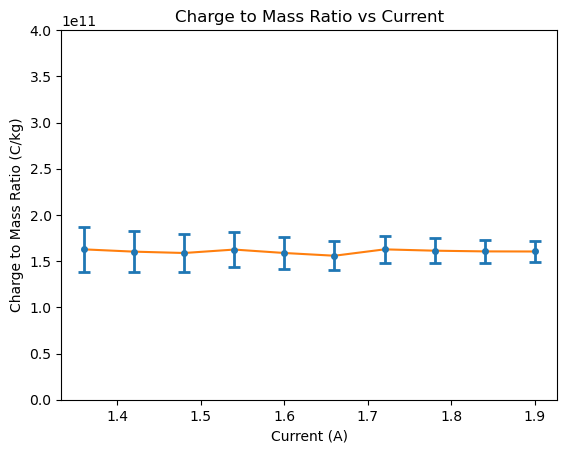

Path radii: 0.043 meters
Radius Uncertainty: 0.0041
magnetic field: 1.15e-03
Mag Uncertainty: 9.08e-04
E/M: 1.63e+11
E/M Uncertainty: 2.42e+10
Weighted Average E/M: 1.60e+11


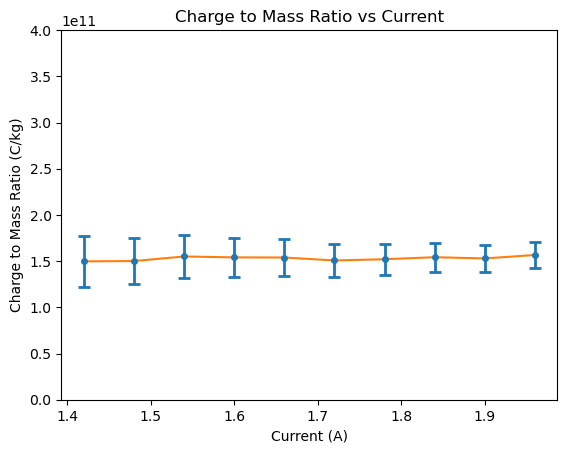

Path radii: 0.048 meters
Radius Uncertainty: 0.00457
magnetic field: 1.20e-03
Mag Uncertainty: 9.41e-04
E/M: 1.50e+11
E/M Uncertainty: 2.75e+10
Weighted Average E/M: 1.53e+11


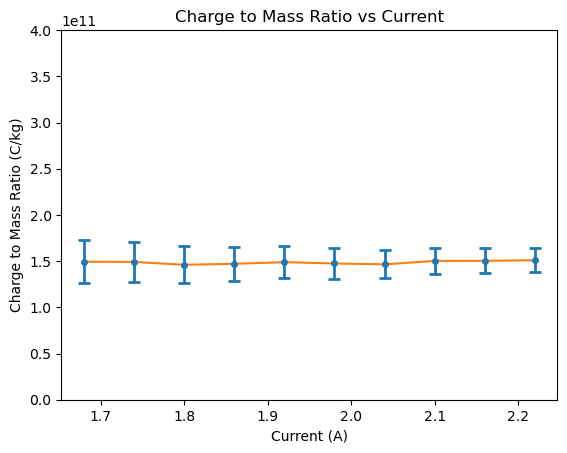

Path radii: 0.0445 meters
Radius Uncertainty: 0.00372
magnetic field: 1.42e-03
Mag Uncertainty: 1.09e-03
E/M: 1.49e+11
E/M Uncertainty: 2.30e+10
Weighted Average E/M: 1.49e+11


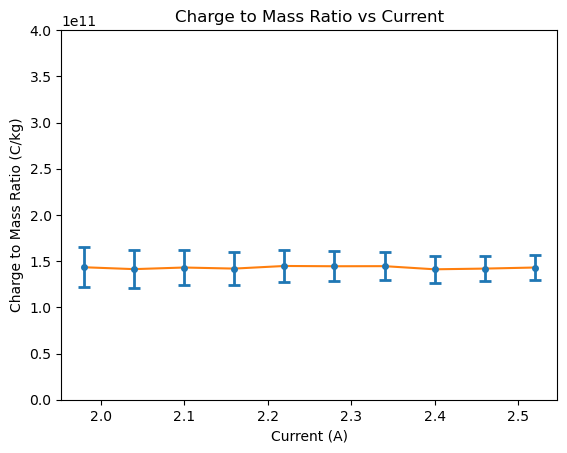

Path radii: 0.0445 meters
Radius Uncertainty: 0.00322
magnetic field: 1.68e-03
Mag Uncertainty: 1.26e-03
E/M: 1.43e+11
E/M Uncertainty: 2.17e+10
Weighted Average E/M: 1.43e+11


In [281]:
trial_200.end_results()
trial_250.end_results()
trial_300.end_results()
trial_400.end_results()